Trial 1 Complete [01h 04m 20s]
val_accuracy: 0.7614814639091492

Best val_accuracy So Far: 0.7614814639091492
Total elapsed time: 01h 04m 20s

The hyperparameter search is complete. The optimal number of units in the first layer is 128,
in the second layer is 256, the optimal dropout rates are 0.2 and 0.2,
and the optimal learning rate is 0.01.

Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 102s 93ms/step - accuracy: 0.2471 - loss: 2.3050 - val_accuracy: 0.2215 - val_loss: 4.7965 - learning_rate: 0.0100
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.4999 - loss: 1.3675 - val_accuracy: 0.1922 - val_loss: 6.8833 - learning_rate: 0.0100
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.5132 - loss: 1.3174 - val_accuracy: 0.2980 - val_loss: 2.5698 - learning_rate: 0.0100
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.5271 - loss: 1.2698 - val_accuracy: 0.5391 - val_loss: 1.2164 - learning_rate: 0.0100
Epoch 5/100
675/675 ━━━━━━━━━━━

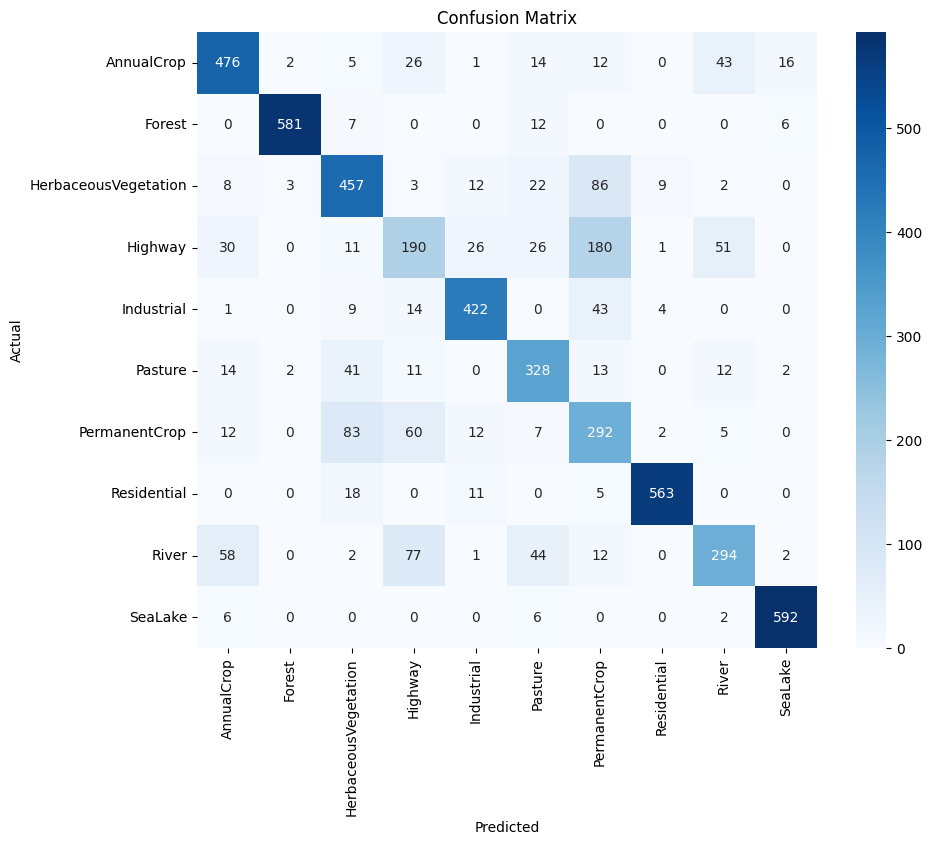

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LSTM, TimeDistributed
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt

# Directory of the dataset
dataset_dir = '/kaggle/input/image-dataset/EuroSAT_RGB'

# Categories of the dataset
categories = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Step 1: Convert the images to grayscale and load them into an array
def load_and_preprocess_images(dataset_dir, categories):
    images = []
    labels = []
    for category in categories:
        category_dir = os.path.join(dataset_dir, category)
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))  # Resize for consistency
            
            # Apply histogram equalization to each channel
            for i in range(3):  
                img[:,:,i] = cv2.equalizeHist(img[:,:,i])
            
            images.append(img)
            labels.append(categories.index(category))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load and preprocess images
images, labels = load_and_preprocess_images(dataset_dir, categories)

# Reshape images to add the time dimension (needed for LSTM)
images = images.reshape((-1, 1, 64, 64, 3))  # Adding time dimension

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define a CNN + LSTM hybrid model
def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    
    # Fine-tune the last few layers of ResNet50
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model = Sequential([
    TimeDistributed(base_model, input_shape=(1, 64, 64, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(128, return_sequences=False),
    
    # First Dense Block
    Dense(hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu'),
    BatchNormalization(),
    Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)),
    
    # Second Dense Block
    Dense(hp.Int('units_2', min_value=64, max_value=256, step=64), activation='relu'),
    BatchNormalization(),
    Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)),
    
    # Third Dense Block (Newly Added)
    Dense(hp.Int('units_3', min_value=64, max_value=256, step=64), activation='relu'),
    BatchNormalization(),
    Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)),
    
    # Fourth Dense Block (Newly Added)
    Dense(hp.Int('units_4', min_value=64, max_value=256, step=64), activation='relu'),
    BatchNormalization(),
    Dropout(hp.Float('dropout_4', 0.2, 0.5, step=0.1)),
    
    Dense(len(categories), activation='softmax')
])


    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # Increased trials for better tuning
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='sat_image_classification'
)

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first layer is {best_hps.get('units_1')},
in the second layer is {best_hps.get('units_2')}, the optimal dropout rates are {best_hps.get('dropout_1')} and {best_hps.get('dropout_2')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Step 5: Evaluation

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred_classes, target_names=categories)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
